<a href="https://colab.research.google.com/github/SoniaSong826/CAREN_OpenSim_Pipeline/blob/master/Computed_Muscle_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computed Muscle Control (CMC) with Evaluation and Plot

The purpose of Computed Muscle Control (CMC) is to compute a set of muscle excitations (or, more generally, actuator controls) that will drive a dynamic musculoskeletal model to track a set of desired kinematics in the presence of applied external forces (if applicable).

https://simtk-confluence.stanford.edu/display/OpenSim/Getting+Started+with+CMC

Following code use OpenSim CMCTool to **get the output files** and gives **evaluation results** based on evaluation metrics, finally **plot the line chart** in different colors.

**Author:** Sonia Song

In [2]:
# Install miniconda environment and dependancies
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# install OpenSim via kzts
!conda install -y --prefix /usr/local -c kzts opensim

import opensim as osim

--2020-05-07 19:39:12--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   190MB/s    in 0.4s    

2020-05-07 19:39:13 (190 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - 

## **1.Computed Muscle Control Function**


***-------------------------Parameters-------------------------***


**model_input**: A subject-specific OpenSim model generated by scaling a generic model with the Scale Tool (`.osim`)

**setup_file**: a setup file for the CMC Tool (`.xml`)

**sto_Kinematics**: Contains the time histories of model kinematics, including the joint angles and pelvis translations from RRA. (`.sto`)

**output_dir**: Path to the store all output files

**force_set**: Path to the generic forces sensor xml (`.xml`) 



***-------------------------Output files-------------------------***

**_controls.xml**: Contains the excitations to individual muscles as well as controls for any residual and/or reserve actuators.

**_CMC_forces.sto**: Muscle forces and reserve/residual forces and torques.

**_states.sto**: Model states and muscle states of the simulated motion.


Reference Code:

https://github.com/samsalemi/OpenSim-Python-Simulation/blob/14a8b3ba5e5f409c16b840bb3ea8f580f8044384/CMC.py

In [9]:
import os

input_dir = os.path.abspath('/content/drive/My Drive/CAREN_Pipeline/')

def Computed_Muscle_Control(model_input, sto_Kinematics, force_set, setup_file, output_dir):
    # Load Model
    aModel = osim.Model(model_input)

    # initialize system
    aModel.initSystem()
    cmcTool = osim.CMCTool()
    cmcTool.setModel(aModel)
    cmcTool.setDesiredKinematicsFileName(sto_Kinematics)
    cmcTool.setTaskSetFileName(setup_file)

    # Force Set
    myForceSet = osim.ForceSet(force_set)
    cmcTool.setReplaceForceSet(False)
    cmcTool.setResultsDir(output_dir)

    cmcTool.run()
    cmcTool.printToXML(output_dir + 'CMC_Setup_Output.xml')
    print(f"COMPLETE Computed Muscle Control FOR: {sto_Kinematics}")


model = input_dir + '/CMC/gait2354_simbody_scaled.osim'
Desired_Kinematics_File = input_dir + '/CMC/3DGaitModel2354_Kinematics_q.sto'
force_set = input_dir + '/CMC/gait2354_CMC_Actuators.xml'
setup_file = input_dir + '/CMC/CMC_Setup.xml'
output_dir = input_dir + '/CMC_Result'
Computed_Muscle_Control(model, Desired_Kinematics_File, force_set, setup_file, output_dir)

COMPLETE Computed Muscle Control FOR: /content/drive/My Drive/CAREN_Pipeline/CMC/3DGaitModel2354_Kinematics_q.sto


## **2.Evaluation for the CMC Result**
Print the evaluation result and plot the graph.
Use for `abc_pErr.sto` and `abc_Actuation_force.sto` files.
The evalution metrics refers to:

https://simtk-confluence.stanford.edu/display/OpenSim/Getting+Started+with+CMC
https://github.com/opensim-org/opensim-models/blob/master/Tutorials/Design_to_Reduce_Metabolic_Cost/Scripts/CMC_EvaluateResults.py

### Usage:
Change the file path and the label of data you want to evaluate.
```
sto_file_err = '/content/drive/My Drive/CAREN_Pipeline/CMC/subject01_walk1_pErr.sto'
evaluation_of_perr (sto_file_err, ['pelvis_tilt','hip_flexion_r','knee_angle_r','ankle_angle_r'])

sto_file_force = '/content/drive/My Drive/CAREN_Pipeline/CMC/subject01_walk1_Actuation_force.sto'
evaluation_of_force (sto_file_force, ['FX','FY','FZ'])
```



Evaluation Result for: pelvis_tilt is GOOD.
Evaluation Result for: hip_flexion_r is GOOD.
Evaluation Result for: knee_angle_r is GOOD.
Evaluation Result for: ankle_angle_r is GOOD.


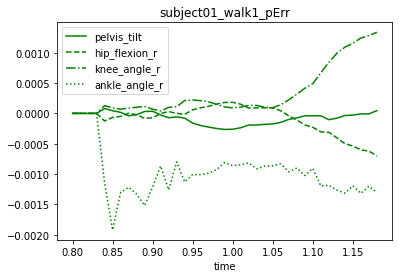

Evaluation Result for: FX is GOOD.
Evaluation Result for: FY is OKAY.
Evaluation Result for: FZ is GOOD.


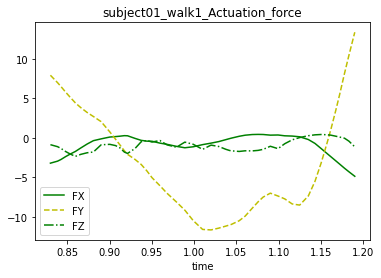

In [0]:
import os
import numpy as np
import statistics
from itertools import cycle
import matplotlib.pyplot as plt

def read_motion_file(filename):
    """ Reads OpenSim .sto files.
    Parameters
    ----------
    filename: absolute path to the .sto file
    Returns
    -------
    header: the header of the .sto
    labels: the labels of the columns
    data: an array of the data
    """

    if not os.path.exists(filename):
        print('file do not exists')

    file_id = open(filename, 'r')

    # read header
    next_line = file_id.readline()
    header = [next_line]
    nc = 0
    nr = 0
    while not 'endheader' in next_line:
        if 'datacolumns' in next_line:
            nc = int(next_line[next_line.index(' ') + 1:len(next_line)])
        elif 'datarows' in next_line:
            nr = int(next_line[next_line.index(' ') + 1:len(next_line)])
        elif 'nColumns' in next_line:
            nc = int(next_line[next_line.index('=') + 1:len(next_line)])
        elif 'nRows' in next_line:
            nr = int(next_line[next_line.index('=') + 1:len(next_line)])

        next_line = file_id.readline()
        header.append(next_line)

    # process column labels
    next_line = file_id.readline()
    if next_line.isspace() == True:
        next_line = file_id.readline()

    labels = next_line.split()

    # get data
    data = []
    for i in range(1, nr + 1):
        d = [float(x) for x in file_id.readline().split()]
        data.append(d)

    file_id.close()

    return header, labels, data

# Get the labels of data in sto file in list format.
def get_datalist_by_name (sto_file, label_name):
    list_of_data = []
    header = read_motion_file(sto_file)[0]
    labels = read_motion_file(sto_file)[1]
    data = read_motion_file(sto_file)[2]

    for i in range(0, len(labels)):
        if labels[i] == label_name:
            break
    
    for j in range(0, len(data)):
        list_of_data.append(data[j][i])
    
    return list_of_data

# Calculate the peak residual of a list
# Defined as the max of absolute distances between average number and each 
# number in the list.
def get_peak_residual (list_of_data):
    mean = statistics.mean(list_of_data)
    peak_residual = -999

    for i in range(0, len(list_of_data)):
        distance = abs(mean - list_of_data[i])
        if peak_residual < distance:
            peak_residual = distance
    
    return peak_residual

# Return the evaluation result as 'GOOD', 'OKAY' or 'BAD'.
# Referring to:
# https://simtk-confluence.stanford.edu/display/OpenSim/Getting+Started+with+CMC
def get_evl_of_error (list_of_data):
    if get_peak_residual(list_of_data) <= 0.0349:
        return 'GOOD'
    elif get_peak_residual(list_of_data) <= 0.0873:
        return 'OKAY'
    else:
        return 'BAD'

def get_evl_of_force (list_of_data):
    if get_peak_residual(list_of_data) <= 10:
        return 'GOOD'
    elif get_peak_residual(list_of_data) <= 25:
        return 'OKAY'
    else:
        return 'BAD'

# In the figure, data of GOOD evaluation result is drew as GREEN.
# OKAY -> YELLOW
# BAD -> RED
def get_color (evl_result):
    if evl_result == 'GOOD':
        return 'g'
    elif evl_result == 'OKAY':
        return 'y'
    else:
        return 'r'

# Simply print the evaluation results
def print_error_info (sto_file, label_name):
    curve = get_datalist_by_name(sto_file, label_name)
    result = get_evl_of_error(curve)

    print(f"Evaluation Result for: {label_name} is {result}")

def print_force_info (sto_file, label_name):
    curve = get_datalist_by_name(sto_file, label_name)
    result = get_evl_of_force(curve)

    print(f"Evaluation Result for: {label_name} is {result}.")


# Get the filename without the extension from a path
# /path/to/some/file.txt => file
def get_filename_without_ext (filepath):

    return os.path.splitext(os.path.basename(filepath))[0]

# The main function of the evaluation process including 
# print and plot the line chart
def evaluation_of_perr (sto_file, list_of_lables):
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)

    for label in list_of_lables:
        print_force_info (sto_file, label)
    
    time = get_datalist_by_name(sto_file, 'time')
    curve_set = []
    for label in list_of_lables:
        curve_set.append(get_datalist_by_name(sto_file, label))
    
    plt.title(get_filename_without_ext(sto_file))
    for i in range(0, len(curve_set)):
        plt.plot(time, curve_set[i], (get_color(get_evl_of_error(curve_set[i])) + next(linecycler)), label=list_of_lables[i])
    plt.xlabel('time')
    plt.legend()
    plt.show()


def evaluation_of_force (sto_file, list_of_lables):
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)

    for label in list_of_lables:
        print_force_info (sto_file, label)
    
    time = get_datalist_by_name(sto_file, 'time')
    curve_set = []
    for label in list_of_lables:
        curve_set.append(get_datalist_by_name(sto_file, label))
    
    plt.title(get_filename_without_ext(sto_file))
    for i in range(0, len(curve_set)):
        plt.plot(time, curve_set[i], (get_color(get_evl_of_force(curve_set[i])) + next(linecycler)), label=list_of_lables[i])
    plt.xlabel('time')
    plt.legend()
    plt.show()


# Change the file path and labels of data to run the evaluation.
sto_file_err = '/content/drive/My Drive/CAREN_Pipeline/CMC/subject01_walk1_pErr.sto'
evaluation_of_perr (sto_file_err, ['pelvis_tilt','hip_flexion_r','knee_angle_r','ankle_angle_r'])

sto_file_force = '/content/drive/My Drive/CAREN_Pipeline/CMC/subject01_walk1_Actuation_force.sto'
evaluation_of_force (sto_file_force, ['FX','FY','FZ'])


Refer to the original code in OpenSim GUI:

https://github.com/opensim-org/opensim-models/blob/master/Tutorials/Design_to_Reduce_Metabolic_Cost/Scripts/CMC_EvaluateResults.py



In [0]:
# --------------------------------------------------------------------------- #
# OpenSim: CMC_EvaluateResults.py                                             #
# --------------------------------------------------------------------------- #
# OpenSim is a toolkit for musculoskeletal modeling and simulation,           #
# developed as an open source project by a worldwide community. Development   #
# and support is coordinated from Stanford University, with funding from the  #
# U.S. NIH and DARPA. See http://opensim.stanford.edu and the README file     #
# for more information including specific grant numbers.                      #
#                                                                             #
# Copyright (c) 2005-2017 Stanford University and the Authors                 #
# Author(s): Ayman Habib                                                      #
#                                                                             #
# Licensed under the Apache License, Version 2.0 (the "License"); you may     #
# not use this file except in compliance with the License. You may obtain a   #
# copy of the License at http://www.apache.org/licenses/LICENSE-2.0           #
#                                                                             #
# Unless required by applicable law or agreed to in writing, software         #
# distributed under the License is distributed on an "AS IS" BASIS,           #
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.    #
# See the License for the specific language governing permissions and         #
# limitations under the License.                                              #
# --------------------------------------------------------------------------- #
# Import needed packages

# Utils contains tools to browse for files and folders
import opensim
import matplotlib.pyplot as plt

# Obtain Directory containing CMC results
#resultsFolderCMC = getInstallDir() + "/Models/gait10dof18musc/CMC/ResultsCMC"
#resultsFolderCMC = utils.FileUtils.getInstance().browseForFolder("Select the folder with CMC Results",1);

####################################
# Plot kinematics errors
# Create Plotter panel
pErrPlot = createPlotterPanel("Kinematics Tracking Errors for CMC")

# Load and plot kinematics data from CMC
src = addDataSource(pErrPlot, '/content/drive/My Drive/CAREN_Pipeline/CMC/subject01_walk1_pErr.sto')
addCurve(pErrPlot, src, "time", "pelvis_tilt")
addCurve(pErrPlot, src, "time", "hip_flexion_r")
addCurve(pErrPlot, src, "time", "knee_angle_r")
addCurve(pErrPlot, src, "time", "ankle_angle_r")

thresholdErrorGood =  modeling.Constant(0.0349)
thresholdErrorGood.setName('GOOD')
addFunctionCurve(pErrPlot, thresholdErrorGood)
setCurveColor(pErrPlot, 4, 0.0, 1.0, 0.0)

thresholdErrorGoodNeg =  modeling.Constant(-0.0349)
thresholdErrorGoodNeg.setName('GOOD')
addFunctionCurve(pErrPlot, thresholdErrorGoodNeg)
setCurveColor(pErrPlot, 5, 0.0, 1.0, 0.0)

thresholdErrorOK =  modeling.Constant(0.0873)
thresholdErrorOK.setName('OK')
addFunctionCurve(pErrPlot, thresholdErrorOK)
setCurveColor(pErrPlot, 6, 1.0, 0.6, 0.4)

thresholdErrorOKNeg =  modeling.Constant(-0.0873)
thresholdErrorOKNeg.setName('OK')
addFunctionCurve(pErrPlot, thresholdErrorOKNeg)
setCurveColor(pErrPlot, 7, 1.0, 0.6, 0.4)

##############################
# Plot the residual forces and moments
residualForcePlot = createPlotterPanel("Residual Forces and Moments")
src = addDataSource(residualForcePlot, resultsFolderCMC+"/walk_subject_Actuation_force.sto")

# Add data to plots, label plots in legend
addCurve(residualForcePlot, src, "time", "FX")
addCurve(residualForcePlot, src, "time", "FY")
addCurve(residualForcePlot, src, "time", "MZ")

# Plot threshold values
thresholdResidualForceGood =  modeling.Constant(10)
thresholdResidualForceGood.setName('GOOD')
addFunctionCurve(residualForcePlot, thresholdResidualForceGood)
setCurveColor(residualForcePlot, 3, 0.0, 1.0, 0.0)

thresholdResidualForceGoodNeg =  modeling.Constant(-10)
thresholdResidualForceGoodNeg.setName('GOOD')
addFunctionCurve(residualForcePlot, thresholdResidualForceGoodNeg)
setCurveColor(residualForcePlot, 4, 0.0, 1.0, 0.0)

thresholdResidualForceOK =  modeling.Constant(25)
thresholdResidualForceOK.setName('OK')
addFunctionCurve(residualForcePlot, thresholdResidualForceOK)
setCurveColor(residualForcePlot, 5, 1.0, 0.6, 0.4)

thresholdResidualForceOKNeg =  modeling.Constant(-25)
thresholdResidualForceOKNeg.setName('OK')
addFunctionCurve(residualForcePlot, thresholdResidualForceOKNeg)
setCurveColor(residualForcePlot, 6, 1.0, 0.6, 0.4)

##############################
# Plot the reserve actuator forces
reserveForcePlot = createPlotterPanel("Reserve Actuators")
src = addDataSource(reserveForcePlot, resultsFolderCMC+"/walk_subject_Actuation_force.sto")

# Add data to plots, label plots in legend
addCurve(reserveForcePlot, src, "time", "hip_flexion_r_reserve")
addCurve(reserveForcePlot, src, "time", "knee_angle_r_reserve")
addCurve(reserveForcePlot, src, "time", "ankle_angle_r_reserve")
addCurve(reserveForcePlot, src, "time", "lumbar_extension_reserve")

# Plot threshold values
thresholdReserveForceGood =  modeling.Constant(25)
thresholdReserveForceGood.setName('GOOD')
addFunctionCurve(reserveForcePlot, thresholdReserveForceGood)
setCurveColor(reserveForcePlot, 4, 0.0, 1.0, 0.0)

thresholdReserveForceGoodNeg =  modeling.Constant(-25)
thresholdReserveForceGoodNeg.setName('GOOD')
addFunctionCurve(reserveForcePlot, thresholdReserveForceGoodNeg)
setCurveColor(reserveForcePlot, 5, 0.0, 1.0, 0.0)